Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


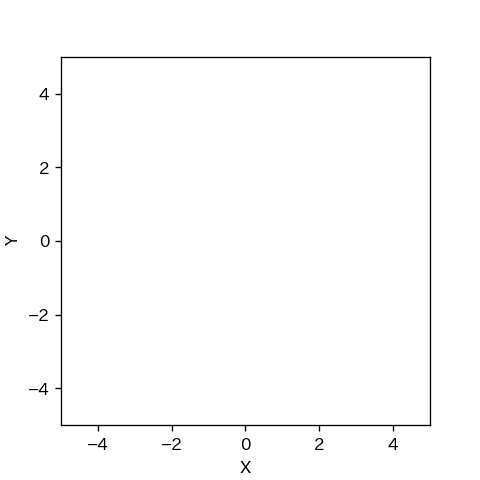

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red", expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


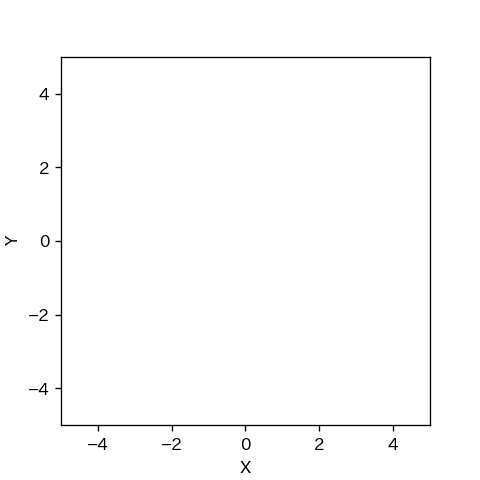

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.98725671 0.87380466 1.44510771] 推定値: [1.09553885 1.29202875 1.40286579] 誤差: 0.43201436732669135
1
1 真値: [-0.79536361  1.90859719  4.11363084] 推定値: [-1.08346504  1.80504025  4.06766353] 誤差: 0.30614779462404923
2
2 真値: [-0.24548414  2.11979225  3.34477431] 推定値: [-0.55863029  2.1781703   3.36313877] 誤差: 0.318541220132153
3
3 真値: [-0.0809785   2.20817511  3.41708813] 推定値: [-0.60034692  2.97052049  3.56247893] 誤差: 0.9224500204285253
4
4 真値: [1.32598226 2.35043466 2.13064109] 推定値: [1.48463911 2.05756594 2.25185324] 誤差: 0.3330826945612315
5
5 真値: [0.23457934 1.89826096 3.00485236] 推定値: [0.22260064 2.50601267 3.09858542] 誤差: 0.6078697417263775
6
6 真値: [-0.52845866  1.75210511  3.54965585] 推定値: [-0.79206163  1.11869988  3.38413242] 誤差: 0.6860675635113446
7
7 真値: [-1.81165531  1.83269879  4.27179479] 推定値: [-1.83044383  2.12108367  4.42879385] 誤差: 0.28899627324322497
8
8 真値: [0.61800825 0.27434395 0.87622105] 推定値: [1.19476872 0.34379406 1.04915761] 誤差: 0.580926806914527
9
9 真値: [1.482401

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.22058219  0.63928599  5.61454142] 推定値: [-0.02304987  0.14976638  5.58271135] 誤差: 0.5278716355422636
19
21 真値: [-0.15695885  1.50781408  3.55351777] 推定値: [-0.16298445  1.71468436  3.65075296] 誤差: 0.20695801366243433
20
[3.919514832530439]
22 真値: [0.67279344 1.50435734 2.20410503] 推定値: [-2.19933605 -1.32932921  1.30353309] 誤差: 4.034712788008855
23 真値: [0.94583173 0.30631881 0.54548092] 推定値: [1.0540529  0.60679279 0.54039258] 誤差: 0.3193688106922451
21
24 真値: [1.07286649 1.30254798 1.77123795] 推定値: [-0.54755904  2.12794131  3.95134787] 誤差: 1.8185304631885655
25 真値: [0.23624147 1.84169348 2.60849213] 推定値: [0.13960254 1.20966736 2.49732796] 誤差: 0.6393716394527659
22
26 真値: [-0.8044014   1.55420168  3.83313174] 推定値: [-0.45158778  1.2039542   3.64402748] 誤差: 0.49714259136589134
23
27 真値: [0.04192493 1.89021837 2.93860431] 推定値: [0.50904132 1.90487938 2.91134704] 誤差: 0.4673464107298786
24
28 真値: [-0.60311644  0.70699814  5.15617884] 推定値: [-0.43995757  0.90718427  5.18978065] 誤差: 0.258